<a href="https://colab.research.google.com/github/guiguilhermegui/TF/blob/main/modelo_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Hydrogeophysical modelling

Coupled hydrogeophysical modelling example. This essentially represents the
forward modelling step of the example presented in section 3.2 of the [pyGIMLi
paper](http://www.sciencedirect.com/science/article/pii/S0098300417300584/pdfft?md5=44253eaacd5490e3fb32210671672496&pid=1-s2.0-S0098300417300584-main.pdf).


In [1]:
# Checkout www.pygimli.org for more examples
#!pip install pygimli tetgen

```mermaid
%%{init: { "sequence": { "mirrorActors":True," maxTextSize":50000 }}}%%
graph TB
    subgraph B1[Import Libraries]
        direction TB
            B1_1[import numpy as np]
            B1_2[import matplotlib.pyplot as plt]
            B1_3[import pygimli as pg]
            B1_4[import pygimli.meshtools as mt]
            B1_5[import pygimli.physics.ert as ert]
            B1_6[import pygimli.physics.petro as petro]
            B1_7[from pygimli.physics import ERTManager]
    end
    B --> B1 

    subgraph C1[Define Parameters]
        direction TB
            C1_1[Define Spatial Parameters]
            C1_2[Define Hydraulic Parameters]
            C1_3[Define Temporal Parameters]
            C1_4[Calculate Relative Spatial Parameters]
            C1_5[Calculate Electrode Spacing]
            C1_6[Calculate Simulation Time]
    end
    C --> C1 

    subgraph D1[Geometry Definition]
        direction TB
            D1_1[Create World Geometry]
            D1_2[Create Boreholes]
            D1_3[Combine Geometries]
    end
    D --> D1 

    subgraph E1[Boundary Conditions]
        direction TB
            E1_1[Define Hydraulic Potential Boundary Conditions]
            E1_2[Define Boundary Markers for Boreholes]
            E1_3[Define Boundary Markers for Terrain]
    end
    E --> E1 

    subgraph F1[Hydraulic Potential Model]
        direction TB
            F1_1[Map Conductivity Values]
            F1_2[Solve Finite Elements for Hydraulic Potential]
    end
    F --> F1 

    subgraph G1[Calculate Velocity]
        direction TB
            G1_1[Calculate Gradient of Hydraulic Potential]
    end
    G --> G1 

    subgraph H1[Saline Concentration]
        direction TB
            H1_1[Define Source Vector]
            H1_2[Calculate Saline Concentration for Each Cell]
    end
    H --> H1 

    subgraph I1[ADV DISP Model]
        direction TB
            I1_1[Calculate Dispersion]
            I1_2[Solve Finite Volume for Injection Time]
            I1_3[Solve Without Injection]
    end
    I --> I1 

    subgraph J1[ERT Mesh Definition]
        direction TB
            J1_1[Create ERT Data]
            J1_2[Create ERT Mesh]
    end
    J --> J1 

    subgraph K1[Archie's Law Application]
        direction TB
            K1_1[Calculate Fluid Conductivity]
            K1_2[Calculate Bulk Resistivity]
            K1_3[Apply Background Resistivity Model]
    end
    K --> K1 

    subgraph L1[ERT Simulation]
        direction TB
            L1_1[Simulate Apparent Resistivities]
            L1_2[Filter Negative Data Values]
            L1_3[Calculate Statistics for Apparent Resistivities]
    end
    L --> L1 

    subgraph M1[Inversion and Visualization]
        direction TB
            M1_1[Create Data Container for Inversion]
            M1_2[Add Error Values]
            M1_3[Initialize ERTManager]
            M1_4[Invert Data]
    end
    M --> M1 
    subgraph Passos
        A[Início simulação] --> B[Import Libraries]
        B --> C[Define Parameters]
        C --> D[Geometry Definition]
        D --> E[Boundary Conditions]
        E --> F[Hydraulic Potential Model]
        F --> G[Calculate Velocity]
        G --> H[Saline Concentration]
        H --> I[ADV DISP Model]
        I --> J[ERT Mesh Definition]
        J --> K[Archie's Law Application]
        K --> L[ERT Simulation]
        L --> M[Inversion and Visualization]
    end

    click B call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L12")
    click C call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L22")
    click D call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L82")
    click E call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L122")
    click F call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L162")
    click G call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L202")
    click H call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L242")
    click I call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L282")
    click J call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L322")
    click K call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L362")
    click L call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L402")
    click M call linkCallback("c:/Users/guilh/Desktop/gimli/TF/Simu/3camadas_cell.ipynb#L442")
```

In [2]:

# imports

import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager

In [3]:

### Parametros
## Espaciais
# Espaciais dos furos
bores = [-20, -15, -10, -5, 0, 5, 10, 15]                       # Posição central dos furos
prof_poco=-0.9
altura_poco= -0.1
raio_poco=0.35   #precisa ser decimal Ex:"3.00001"

# Espaciais do Terreno
box_esq=-30
box_dir=30
box_top=0.01
box_bottom=-20

# Espaciais discretização de células
mesh_area=0.3               # area da mesh em metros^2
mesh_quality=30             # qualidade da mesh evitar valores acima de 33 por questões de performance

## Hidráulicos do meio
# Condutividade Hidráulica em m/s 
K_poco = 1e0       #poço
K_mundo1 = 1e-6    #latossolo
K_mundo2 = 1e-1     #fratura 
K_mundo3 = 1e-3    #rocha
#Marcador de região do modelo
Mk_poco = 0       #poço
Mk_mundo1 = 1    #latossolo     
Mk_mundo2 = 2    #fratura 
Mk_mundo3 = 3    #rocha
L_mundo1 = -2   
L_mundo2 = -15

# Resumir Condutividades hidráulicas em uma variável só
kMap = [[Mk_mundo1, K_mundo1],  [Mk_poco, K_poco], [Mk_mundo2,K_mundo2],[Mk_mundo3,K_mundo3] ]   #Use [[RegionMarker, ConductivityValue], ...]

# Propriedades do meio poroso ADV
phi = 0.3                   # Porosidade meio
D = 0.01                    # Coeficiente de dispersão m^2/s


## Traçador                  # Condutividade elétrica da água em S/m
sigma_a = -0.00031            
sigma_bx = 0.19330           # Termos da Eq. de Resistência/concentração = A+bx   
TracerCon = 13.27            # Concentração em g/l
cementation_exponent = 1.1  # Exponente de cimentação para a resistividade do solo
res_water = 10000            # Resistividade da água em Ohm.m


# Resistividade do meio em Ohm.m
Layer0=box_top
RLayer0=300
Layer1=-2                    # Prof. da camada 1
RLayer1=150                  # Resistividade da camada 1
Layer2=-8                    # Prof. da camada 2
RLayer2=4464                 # Resistividade da camada 2
Layer3=-24                   # Prof. da camada 3
RLayer3=3300                 # Resistividade da camada 4

# Configuração ERT 
ERT_dist= 60                # Distância total dos eletrodos em m
ERT_elecs = 60               # Quantidade de eletrodos
ERT_spac = 5               # Espaçamento entre os eletrodos em m
ERT_Array = 'dd'             # wn, ws, wa, wb, dd, pd, pp, grad 
nLayers=3

y_limit = 20                 # Set the Y-axis limit to cut off below DD12



# Temporais
TimeSimu_days = 3                     # Tempo de simulação em dias  
TimeSimu_sec = TimeSimu_days*24*60*60   # Tempo de simulação em seg  
TimeSimu_steps = 60*60                  # Quantidade de passos pra simulação
number_of_timesERT = 12        # Número de vezes que a simulação de ERT é executada


""" Cálculos Espaciais relativos do furo """
esq = '.' + f'{raio_poco:.2f}'.split('.')[1]
dir = '.' + f'{1 - raio_poco:.2f}'.split('.')[1]#print(f'raio_poco={raio_poco:.2f} esq={esq} dir={dir}')

""" Cálculo Espaçamento dos eletrodos """
elecs = np.linspace(-ERT_dist/2, ERT_dist/2, ERT_elecs)


""" Cálculo tempo de simulação """
t = pg.utils.grange(0, TimeSimu_sec, n=TimeSimu_steps)


## Geometry definition for the modelling domain



In [4]:
# Criação da geometria de 3 camadas
world = mt.createWorld(start=[box_esq, box_top], end=[box_dir, box_bottom], WorldMarker=False, layers=[L_mundo1,L_mundo2]) 

# Create boreholes
poco = []
for pos in bores:
    poco.append(mt.createRectangle(start=[pos - raio_poco, altura_poco], end=[pos + raio_poco,prof_poco],marker=0)) #marker=42, isHole=True, boundaryMarker=12))
boreholes = poco[0]
for borehole in poco[1:]:
    boreholes = boreholes + borehole


# Create geometry of model
geom = world + boreholes
#pg.show(mesh)

""" node = [] # Print nodes
for i, n in enumerate(geom.nodes()):
    ax.text(n.x(), n.y(), str(i), color='blue', size=10)
    node.append([i, n.x(), n.y()]) """


" node = [] # Print nodes\nfor i, n in enumerate(geom.nodes()):\n    ax.text(n.x(), n.y(), str(i), color='blue', size=10)\n    node.append([i, n.x(), n.y()]) "

### Condições de Fronteira
The problem further boundary conditions of the hydraulic potential. We use
$p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling
domain, equaling a hydraulic gradient of 1.75%.



\begin{split}c \frac{\partial u}{\partial t} & = \nabla\cdot(a \nabla u)
+ b u + f(\mathbf{r},t)~~|~~\Omega_{\text{Mesh}}\\
u & = h~~|~~\Gamma_{\text{Dirichlet}}\\
a\frac{\partial u}{\partial \mathbf{n}} & =
g~~|~~\Gamma_{\text{Neumann}}\\
\alpha u + \beta\frac{\partial u}{\partial \mathbf{n}} & =
\gamma~~|~~\Gamma_{\text{Robin}}\\
\frac{\partial u}{\partial \mathbf{n}} & =
\alpha(u_0-u)~~|~~\Gamma_{\text{Robin}}\end{split}

https://www.pygimli.org/pygimliapi/_generated/pygimli.solver.html#pygimli.solver.solveFiniteElements

In [5]:
# EDP - Condições de Contorno - potencial hidráulico 
basemundo_2 = 0.0             # Definir valores de fronteira pro potencial hidráulico  # fronteiras 1top, 2lat,3_fundo,4latmundo,-2basemundo,-1topomundo
topo7 = 0.9
#laterais8 = h202             # Defina a altura da água nas laterais
#fundo9 = 0.9   #h20          # Defina a altura da água no poço
#pBound = {"Dirichlet": {-2: basemundo_2, -1: topo7}} #{marker: value, ...} #Dirichlet, Neumann, Robin #pBound = pBound.append("Neumann":{2: laterais8, 3:fundo9})
pBound = {"Dirichlet": {-2: basemundo_2, -1:0.0 , 1: topo7}} #{marker: value, ...} #Dirichlet, Neumann, Robin #pBound = pBound.append("Neumann":{2: laterais8, 3:fundo9})

In [6]:
# Marcadores de Fronteira dos buracos

bottom_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[1] ==prof_poco]
side_boundaries = [boundary.id() for boundary in geom.boundaries() if boundary.center()[0] ==box_esq] + [boundary.id() for boundary in geom.boundaries() if boundary.center()[0] ==box_dir]


"""# Atribuição da numeracao das fronteiras boreholes
def pos(count):
    return pg.pos(node[count][1], node[count][2])
for a in range(len(bottom_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(right_boundaries[a]), marker=9)

for a in range(len(right_boundaries)):
    geom.createEdge(geom.node(top_boundaries[a]), geom.node(right_boundaries[a]), marker=8)

for a in range(len(left_boundaries)):
    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(left_boundaries[a]), marker=8)
for a in range(len(top_boundaries)):
    geom.createEdge(geom.node(left_boundaries[a]), geom.node(top_boundaries[a]), marker=7)
"""
#pg.show(geom, label='Boundary marker', showNodes=True,markers=True, showMesh=True, figsize=(15, 8), orientation='vertical' )

'# Atribuição da numeracao das fronteiras boreholes\ndef pos(count):\n    return pg.pos(node[count][1], node[count][2])\nfor a in range(len(bottom_boundaries)):\n    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(right_boundaries[a]), marker=9)\n\nfor a in range(len(right_boundaries)):\n    geom.createEdge(geom.node(top_boundaries[a]), geom.node(right_boundaries[a]), marker=8)\n\nfor a in range(len(left_boundaries)):\n    geom.createEdge(geom.node(bottom_boundaries[a]), geom.node(left_boundaries[a]), marker=8)\nfor a in range(len(top_boundaries)):\n    geom.createEdge(geom.node(left_boundaries[a]), geom.node(top_boundaries[a]), marker=7)\n'

In [7]:
# Overview Condições de Fronteira
print(pBound)
node = geom.nodes()
print(node)  # This will print the object reference again


for i in range(0, len(node), 4):# Print 4 lists of nodes per line, very useful for rectangles models
    print('nodes' + str(node[i:i+4]))
print()
print(geom.nodes())


# %%
print(geom.boundaries)

{'Dirichlet': {-2: 0.0, -1: 0.0, 1: 0.9}}
nodes[	ID: 0, Marker: 0	RVector3: (-30.0, 0.01, 0.0)
, 	ID: 1, Marker: 0	RVector3: (-30.0, -2.0, 0.0)
, 	ID: 2, Marker: 0	RVector3: (-30.0, -15.0, 0.0)
, 	ID: 3, Marker: 0	RVector3: (-30.0, -20.0, 0.0)
]
nodes[	ID: 4, Marker: 0	RVector3: (30.0, -20.0, 0.0)
, 	ID: 5, Marker: 0	RVector3: (30.0, -15.0, 0.0)
, 	ID: 6, Marker: 0	RVector3: (30.0, -2.0, 0.0)
, 	ID: 7, Marker: 0	RVector3: (30.0, 0.01, 0.0)
]
nodes[	ID: 8, Marker: 0	RVector3: (-20.35, -0.1, 0.0)
, 	ID: 9, Marker: 0	RVector3: (-20.35, -0.9, 0.0)
, 	ID: 10, Marker: 0	RVector3: (-19.65, -0.9, 0.0)
, 	ID: 11, Marker: 0	RVector3: (-19.65, -0.1, 0.0)
]
nodes[	ID: 12, Marker: 0	RVector3: (-15.35, -0.1, 0.0)
, 	ID: 13, Marker: 0	RVector3: (-15.35, -0.9, 0.0)
, 	ID: 14, Marker: 0	RVector3: (-14.65, -0.9, 0.0)
, 	ID: 15, Marker: 0	RVector3: (-14.65, -0.1, 0.0)
]
nodes[	ID: 16, Marker: 0	RVector3: (-10.35, -0.1, 0.0)
, 	ID: 17, Marker: 0	RVector3: (-10.35, -0.9, 0.0)
, 	ID: 18, Marker: 0	RVector3:

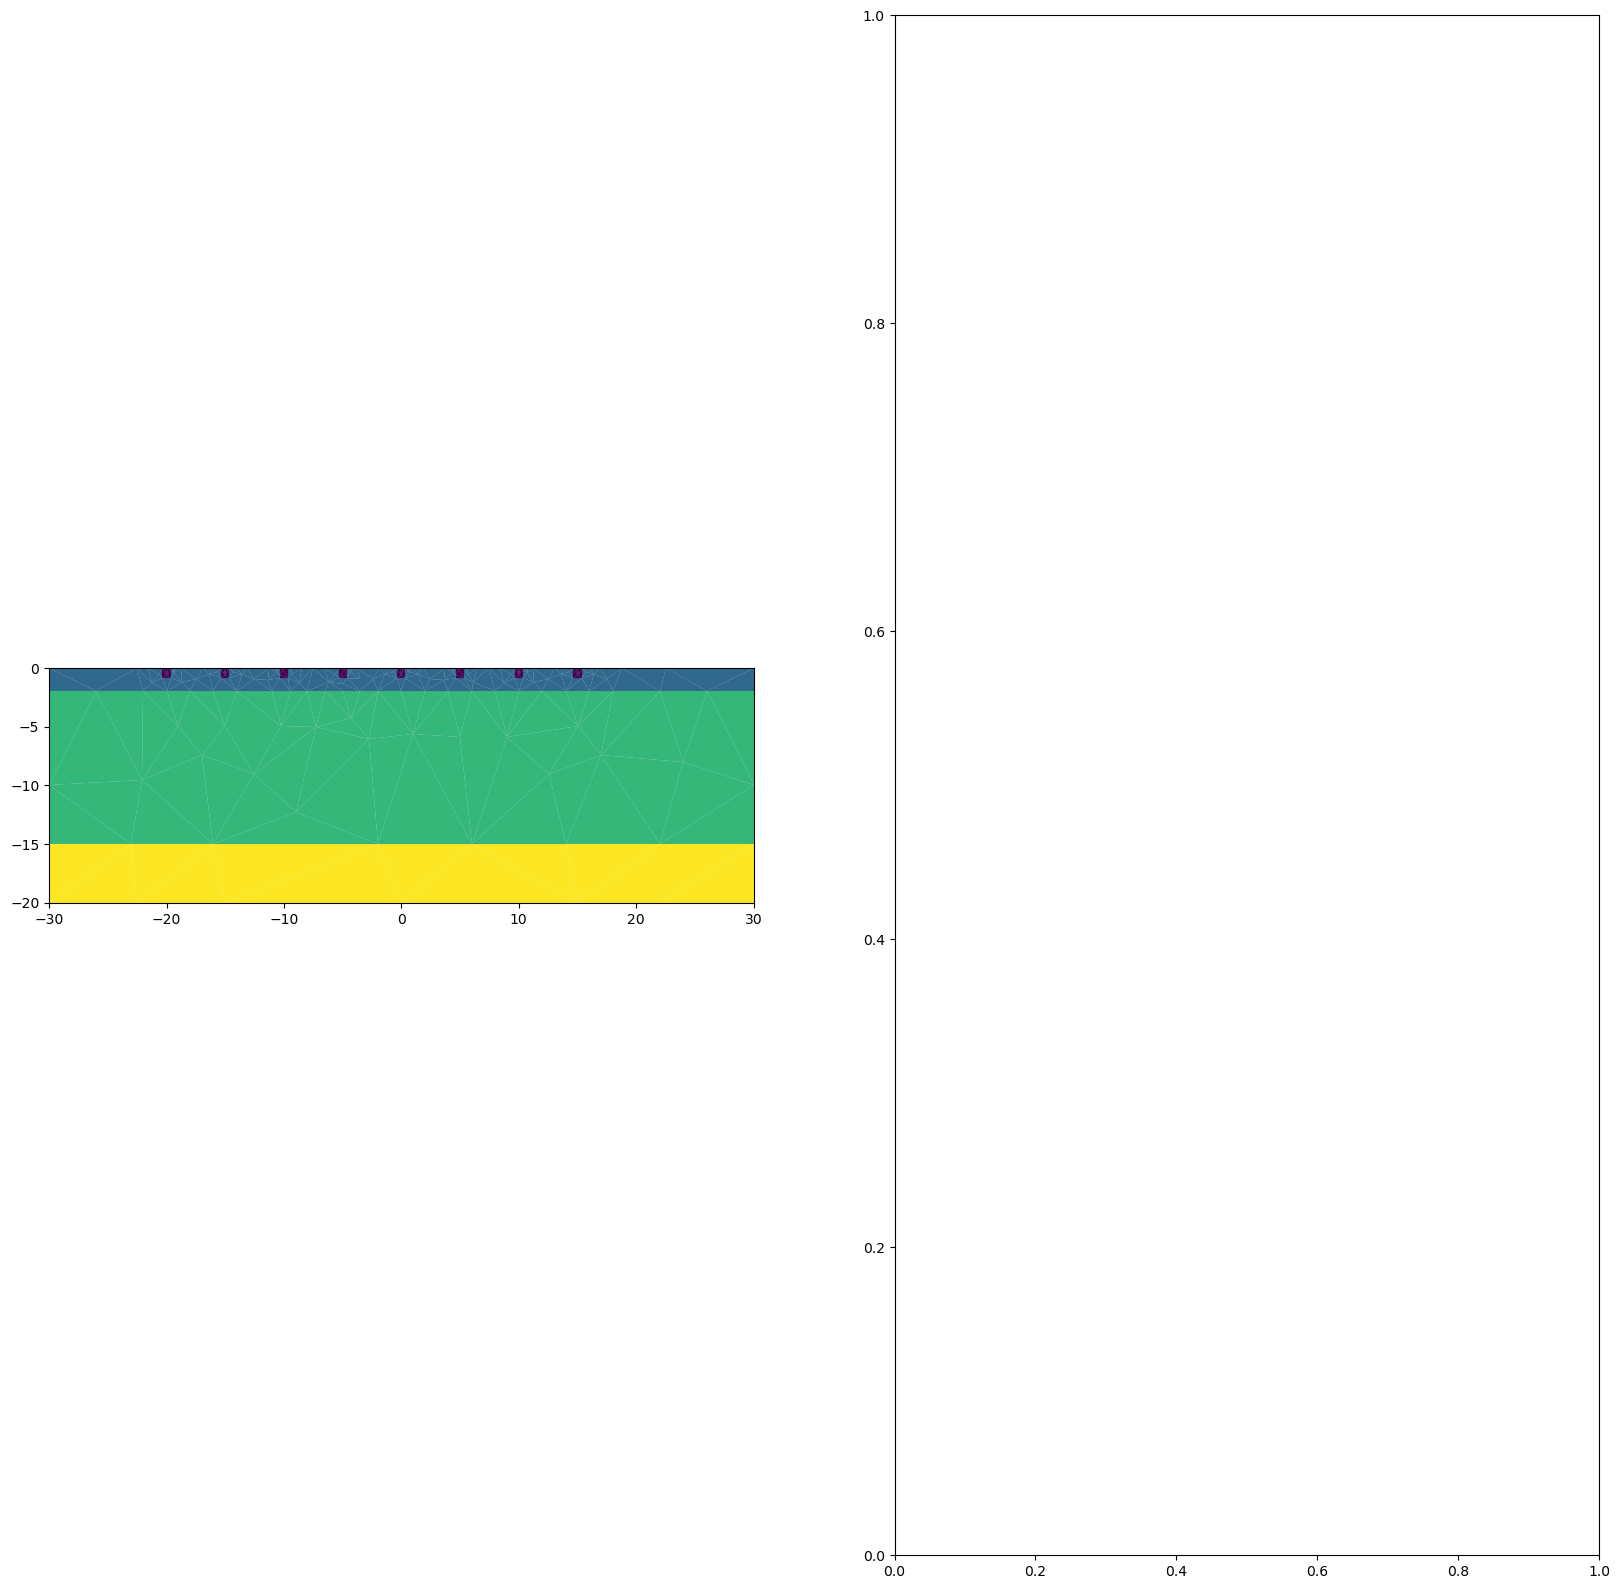

c:\Users\guilh\.conda\envs\pg\Lib\site-packages\pygimli\viewer\mpl\colorbar.py:321: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = cbarTarget.colorbar(gci, cax=cax, orientation=orientation)
c:\Users\guilh\.conda\envs\pg\Lib\site-packages\pygimli\viewer\mpl\colorbar.py:321: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 4 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = cbarTarget.colorbar(gci, cax=cax, orientation=orientation)


<Figure size 640x480 with 0 Axes>

In [8]:
# Marcadores de Fronteira dos Terreno 3 Camadas
fig, axs = plt.subplots(1,2,figsize=(20,20))
pg.show(geom, label='Region Markers', showNodes=True,markers=False, showMesh=False, orientation='vertical',ax=axs[0])

pg.show(geom, label='Boundary marker', showNodes=True,markers=True, showMesh=False, orientation='vertical',ax=axs[1] )
plt.show()

## Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic
movement is governed by Darcy's Law according to:

\begin{align}\frac{K}{\mathbf{v}} + \nabla p & = 0 \\
   \nabla \cdot \mathbf{v} & = 0\\
   \text{leading}\,\,\text{to}\,\,
   \nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and
mapping these to each mesh cell:



Mesh:  Mesh: Nodes: 3505 Cells: 6743 Boundaries: 10247
Assembling time:  0.0758095
Solving time:  0.4789554


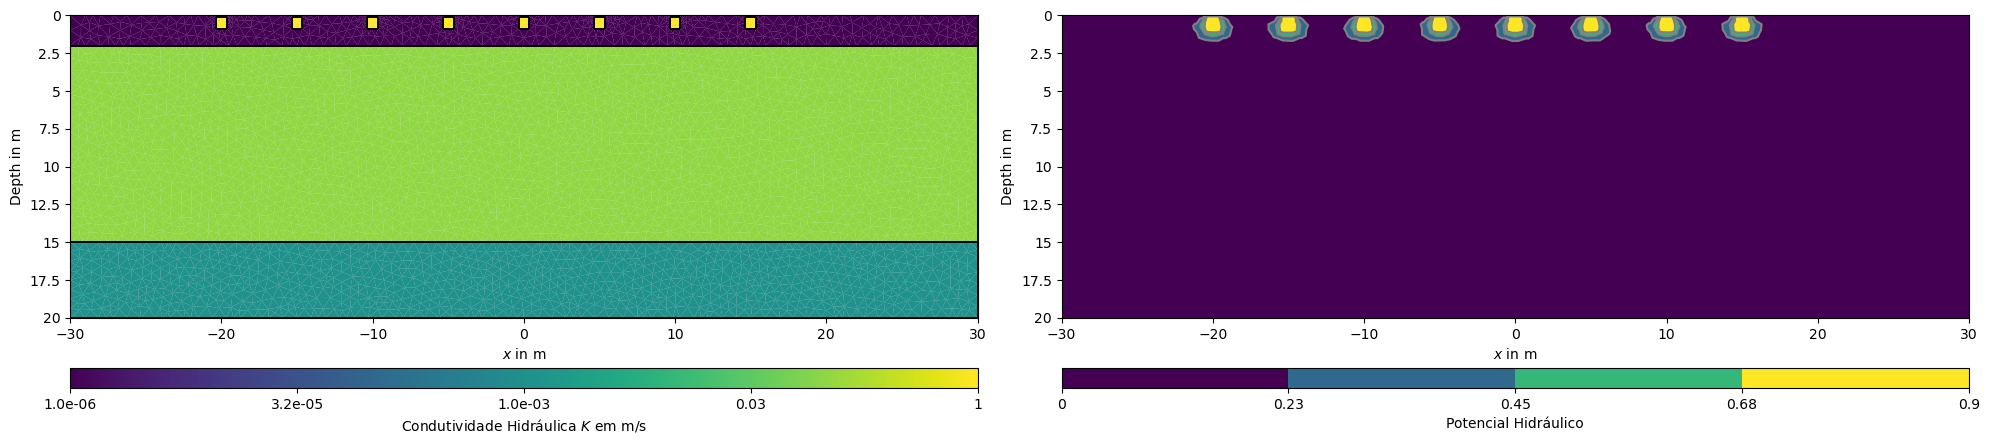

In [9]:
## Resolução K  por Darcy e Potencial por Elementos Finitos
# Map conductivity value per region to each cell in the given mesh

mesh = mt.createMesh(geom, quality=mesh_quality, area=mesh_area, smooth=[1, 10])
K = pg.solver.parseMapToCellArray(kMap, mesh)

#pg.show(mesh, data=K, label='Hydraulic conductivity $K$ in m/s', cMin=1e-10, cMax=1e12, logScale=True, grid=True)

# Resolução da discretização do modelo de potencial hidráulico
#p = np.random.rand(mesh.cellCount())   # Teste aleatorio

# Resolver o modelo de potencial hidráulico
p = pg.solver.solveFiniteElements(mesh, a=K, bc=pBound, verbose=True)#stats=True)

# Atualizar a visualização ou armazenar resultados
fig, axs = plt.subplots(1,2,figsize=(20, 20))
pg.show(mesh, data=K, label='Condutividade Hidráulica $K$ em m/s', cMap= 'viridis',logScale=True, ax=axs[0],orientation='horizontal')
pg.show(mesh, data=p, label='Potencial Hidráulico', cMin=np.min(p), cMax=np.max(p), ax=axs[1],orientation='horizontal')
plt.show()

## Elementos Finitos Velocidade
We can now call the finite element solver with the generated mesh, hydraulic
conductivity and the boundary condition. The sought hydraulic velocity
distribution can then be calculated as the gradient field of
$\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.



(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

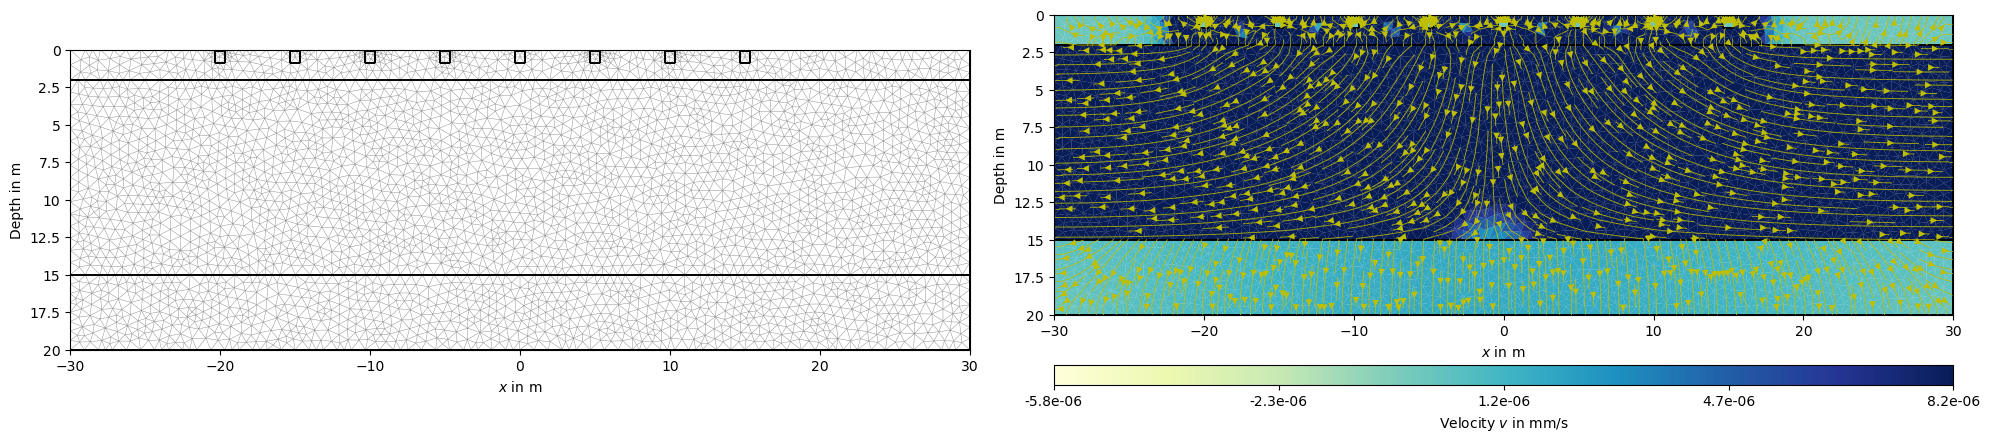

In [10]:
# Resolução da velocidade como o neg. do grad. do Pot. Hid.
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T #4D


fig, axs = plt.subplots(1,2,figsize=(20,10))
pg.show(mesh, data=pg.abs(vel)/1e-2, cMin=np.min(vel), cMax=np.max(vel),
                label='Velocity $v$ in mm/s', ax=axs[1], cMap='YlGnBu', hold=True,showStats=True)
pg.show(mesh, data=vel, color='y', linewidth=0.6, dropTol=1e-12, ax=axs[1],
                hold=True)

pg.show(mesh, color='grey', linewidth=0.2, ax=axs[0],
                label='Malha de discretização ',hold=True)

In [11]:
# Determinação da concentração salina por cada célula do poço
Source_vector = pg.Vector(mesh.cellCount(), 0.0) 

mm_stom_s=1e-3 
ltom3=1e-3
#prism=raio_poco*raio_poco
cil_ret=raio_poco*3.14/2
vol_extrd=cil_ret


for pos in bores:
    for y in np.linspace(prof_poco , altura_poco, num=100):
        sourceCelly = mesh.findCell([pos, y])
        if sourceCelly:
            if Source_vector[sourceCelly.id()]==0:
                Source_vector[sourceCelly.id()] = TracerCon*ltom3/ (sourceCelly.size()*vol_extrd)  # g/l *1e3 /m^3  #aproximação da concentração salina do poço
            for x in np.linspace(pos-raio_poco,pos+raio_poco,num=100):
                sourceCellx = mesh.findCell([x, y])
                Source_vector[sourceCellx.id()] = TracerCon *ltom3/ (sourceCellx.size()*vol_extrd)  # g/m^3


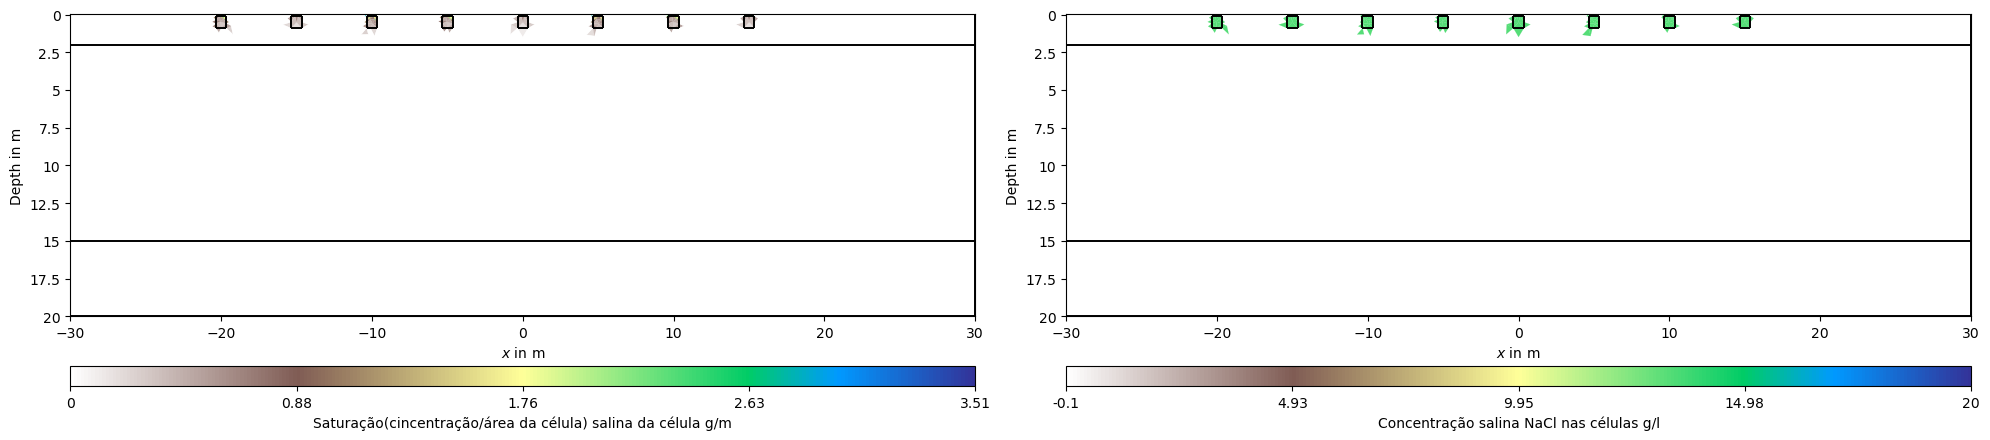

In [12]:

fig, axs = plt.subplots(1,2,figsize=(20,10))
pg.show(mesh, data=Source_vector,
                label='Saturação(cincentração/área da célula) salina da célula g/m', ax=axs[0], cMap='terrain_r', hold=True,showStats=True)
pg.show(mesh, data=Source_vector/Source_vector*TracerCon, ax=axs[1], label='Concentração salina NaCl nas células g/l',cMap='terrain_r',cMax=20)
plt.show()

In [13]:
# Resolução do modelo de ADV DISP da concentração


# Velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)
raiodisp=1
cone=1/3*3.14*(raio_poco**2+raiodisp**2+(raiodisp*raio_poco)) # vol cone de dispersão

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * mm_stom_s *1e5           #* float(cone)  # transform from mm/s to m/s
# Solve for injection time
S=(Source_vector)
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion,  f=S, vel=veln,times=t, scheme='PS', verbose=0)

# Solve without injection starting with last result
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln, u0=c1[-1],times=t, scheme='PS', verbose=0)



c:\Users\guilh\.conda\envs\pg\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


In [14]:

S = pg.RVector(len(Source_vector))  # Initialize S as a zero vector


#Teste modelo de esvaziamento do poço
""" # Definições de variáveis e funções
#h0 = altura_poco            # Altura inicial da água no poço
#h2o = h0 - prof_poco        # Altura da linha da água inicial no poço
#h2o2=0
#y=0.0001
#y = 0.1  # Defina a variação na linha vertical da fronteira
# Defina os parâmetros iniciais hidráulicos
#taxa_de_infiltracao = 0.005 # Taxa de infiltração em m/s
#num_iteracoes = 20          # Número de iterações dt para simulação
#dt = 1                      # Intervalo de tempo em segundos
"""
 
 
#Or "Matlab" code
 
 
 
 

# Loop for each time step
i=0
for i in enumerate(t):
    # Calculate new source vector with decay (adjust decay function as needed)
    S = (Source_vector * ((0/cone))**i) # Usar 1.0 para garantir divisão de ponto flutuante
    i+=1
    c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=S, vel=veln, times=t, scheme='PS', verbose=0)


# Solve without injection after the injection period
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln, u0=c1[-1], times=t, scheme='PS', verbose=0)

TypeError: unsupported operand type(s) for ** or pow(): 'float' and 'tuple'

Courant-Friedrichs-Lewy Number<1

The CFL condition is given by:

CFL = v_max * dt / dx


Reduce the time step size
Increase the spatial step size

In [ ]:
# Stack results together
c = np.vstack((c1, c2))
#c=(c1)


# Calculate statistics
mean_c = np.mean(c)
std_c = np.std(c)
min_c = np.min(c)
max_c = np.max(c)
min_c_calc = 0.1 #mean_c - 1 * std_c
max_c_calc = mean_c + 2 * std_c
print(f"Mean: {mean_c}, Std: {std_c}, Min: {min_c}, Max: {max_c}")

#l=np.size(c,0)
# Visualização da dispersão da concentração no tempo t
fig, ax = plt.subplots(int(TimeSimu_sec/TimeSimu_steps), 3, figsize=(20, 60), sharex=1,sharey=1)
i = 0
for ci in c[0:][::100]: 
    pg.show(mesh, data=ci, cMin=min_c_calc, cMax=max_c_calc, cMap="terrain_r", logScale=True,
            label=f"Concentração NaCl em (g/l) no passo {i}", orientation='horizontal', ax=ax[i // 3, i % 3])
    i += 1


In [ ]:
# ERT definição de malha de interação

ertScheme = ert.createData(elecs=elecs, schemeName=ERT_Array, spacing=ERT_spac)

meshERT = mt.createParaMesh(ertScheme, quality=mesh_quality, paraMaxCellSize=ERT_spac/4e1, nLayers=nLayers,
boundaryMaxCellSize=750, smooth=[1, 2])

pg.show(meshERT,label='Mesh de cálculos ERT',figsize=(10,10),)


## Lei de Archie

$$R_f = R_r (1 - S_w)^m$$
Rf is the fluid resistivity

Rr is the rock resistivity

Sf is the fluid saturation

m is the cementation exponent

In [ ]:
# Simulação elétrica por tempo, concentração para condutividade pela Lei de Archie

timesERT = pg.IVector(np.floor(np.linspace(0, len(c1) - 1, number_of_timesERT)).astype(int)) # Select 10 time frame to simulate ERT data

# Create conductivity of fluid for salt concentration :math:c
sigmaFluid = c1[timesERT] * sigma_bx + sigma_a
c1 = np.array(c1)  # Ensure c is a numpy array

# Calculate bulk resistivity based on Archie's Law, by ratio of res water and sigmaFluid
resBulk = petro.resistivityArchie(rFluid = res_water / sigmaFluid, porosity = phi, m=cementation_exponent, mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount())

for cell in meshERT.cells():
    if cell.center()[1] < -Layer3:
        rho0[cell.id()] = RLayer3
    elif cell.center()[1] < -Layer2:
        rho0[cell.id()] = RLayer2
    elif cell.center()[1] < -Layer1:
        rho0[cell.id()] = RLayer1
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)
""" 
## ISSUE
##
##  Não esquecer de adicionar 
## Adicionar a resistividade de cada camada no modelo
##
##

 """


In [ ]:
# Visualização 
for i in range(len(resis)):
    mean_resis = np.mean(resis[i])
    std_resis = np.std(resis[i])
    min_resis = np.min(resis[i])
    max_resis = np.max(resis[i])
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_resis}, Std: {std_resis}, Min: {min_resis}, Max: {max_resis},")
    print()

In [ ]:
# Simulação resistividade Aparente
ERT = ERTManager(verbose=False)

# Run simulation for the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme, 
                    returnArray=True, verbose=False,)# noiseLevel=1e-2, noiseAbs=1e-6,)
print('Simulated rhoa', rhoa, np.max(rhoa))

# Its possible that there are some negative data values due to noise and
# huge geometric factors. So we need to remove them
#rhoa.markInvalid(rhoa('rhoa') < 0)
#print('Filtered rhoa', rhoa('rhoa'), max(rhoa('rhoa')))
#rhoa.removeInvalid()

# Optional: save the data for further use
#data.save('simple.dat')

# Calculate statistics for rhoa
#Min_calcERT=mean_rhoa-2*std_rhoa
#Max_calcERT=mean_rhoa+2*std_rhoa 
#cMin=1e-4
#cMax=1

# Plot the first 4 timesteps normalized by the first timestep
# Print the statistics


In [ ]:
# visualização Resistividade aparente
fig, axs = plt.subplots(4, 3, figsize=(20, 30), sharex=True, sharey=True)
for i in range(len(rhoa)):
    ax=axs[i // 3, i % 3]
    # Create a copy of the scheme for each visualization
    tempScheme = ertScheme.copy()
    tempScheme.set('rhoa', rhoa[i])
    
    mean_rhoa = np.mean(rhoa[i])
    std_rhoa = np.std(rhoa[i])
    min_rhoa = np.min(rhoa[i])
    max_rhoa = np.max(rhoa[i])
    Min_calcERT=min_rhoa
    Max_calcERT=max_rhoa
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_rhoa}, Std: {std_rhoa}, Min: {min_rhoa}, Max: {max_rhoa}, Min_calcERT: {Min_calcERT}, Max_calcERT: {Max_calcERT},")
    print()

    # Show the data and get the Axes object
    ax, _ = ERT.showData(tempScheme, vals=rhoa[i],cMin=Min_calcERT,cMax=Max_calcERT,LogScale=True,ax=ax)


    ax.set_ylim(y_limit, ax.get_ylim()[1])  # Set the lower limit Y cut-off

    # Optionally, you can add titles or labels
    ax.set_title(f'Timestep {i+1}')
    ax.set_xlabel('Comprimento em metros m')  # Replace with your actual label
    ax.set_ylabel('Níveis de investigação')  # Replace with your actual label

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#Visualização normalizada

fig, axs = plt.subplots(4, 3, figsize=(20, 30), sharex=True, sharey=True)
for i in range(len(rhoa)):
    ax=axs[i // 3, i % 3]
    # Create a copy of the scheme for each visualization
    tempScheme = ertScheme.copy()
    tempScheme.set('rhoa', rhoa[i])
    
    mean_rhoa = np.mean(rhoa[i])
    std_rhoa = np.std(rhoa[i])
    min_rhoa = np.min(rhoa[i])
    max_rhoa = np.max(rhoa[i])
    Min_calcERT=min_rhoa
    Max_calcERT=max_rhoa
    print(f"Timestep {i+1}:")
    print(f"Mean: {mean_rhoa}, Std: {std_rhoa}, Min: {min_rhoa}, Max: {max_rhoa}, Min_calcERT: {Min_calcERT}, Max_calcERT: {Max_calcERT},")
    print()

    # Show the data and get the Axes object
    ax, _ = ERT.showData(tempScheme, vals=rhoa[i]/rhoa[0],cMin=Min_calcERT,cMax=Max_calcERT,LogScale=True,ax=ax)

    ax.set_ylim(y_limit, ax.get_ylim()[1])  # Set the lower limit to depth of DD y axis

    # Optionally, you can add titles or labels
    ax.set_title(f'Timestep {i+1} normalized by Timestep 1')
    ax.set_xlabel('Comprimento em metros')  # Replace with your actual label
    ax.set_ylabel('Níveis de investigação')  # Replace with your actual label

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#Backup
""" ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme,
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], logScale=False, label='Apparent resistivity',) """

In [ ]:
# Create data container for inversion
data = ert.createData(elecs=elecs, schemeName=ERT_Array)
data.set('rhoa', rhoa[0])  # Use first time step for inversion

# Add error values (3% relative error)
data.set('err', np.ones(data.size()) * 0.03)

# Initialize ERTManager with data
mgr = ERTManager(data=data, verbose=False)
mgr.setMesh(meshERT)
mgr.invert()

